In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import psi4

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors

In [2]:
import bayes_opt_dis as bod

In [3]:
smiles_df=pd.read_csv("ProcessedData/smiles_chfcl.csv",index_col=0)
display(smiles_df.head())

,SMILES
0,[H]C(F)(F)C([H])([H])C(F)(F)Cl
1,[H]C(F)(Cl)C([H])([H])C(F)(F)F
2,[H]C(Cl)=C=C([H])Cl
3,[H]C([H])(F)C([H])(F)Cl
4,[H]C([H])(Cl)C(F)(F)C(F)(F)Cl


In [4]:
desc_list = Descriptors.descList

desc_values=[]
mol_list=[]
for i,row in smiles_df.iterrows():
    mol=Chem.MolFromSmiles(row["SMILES"])
    mol_list.append(mol)
    desc_value_row=[]
    for desc in desc_list:
        try:
            desc_value_row.append(desc[1](mol))
        except:
            # エラーが発生したものについてはnp.NaNを代入
            desc_value_row.append(np.NaN)
    desc_values.append(desc_value_row)

In [5]:
# 記述子関数の辞書を作る
desc_dict={}
desc_name=[]
for desc in desc_list:
    desc_dict[desc[0]]=desc[1] 
    desc_name.append(desc[0])
    
logp_list=[]
for mol in mol_list:
    logp_list.append(desc_dict["MolLogP"](mol))
logp_df=pd.DataFrame(logp_list,columns=["LogP"])

In [6]:
desc_df=pd.DataFrame(desc_values,columns=desc_name)
# 欠損値を確認
desc_df.isnull().sum().sum()

3

In [7]:
# 欠損値のある列を削除
desc_df=desc_df.dropna(axis=1)
# 欠損値を確認
desc_df.isnull().sum().sum()

0

In [8]:
# 標準偏差が0のものを除去
desc_df2=desc_df.loc[:,desc_df.std()>0]

In [9]:
# 結合
mol_df=pd.DataFrame(mol_list,columns=["mol"])
desc_df3=pd.concat([smiles_df,mol_df,desc_df2],axis=1)
desc_df3.head()
desc_df3.tail()

,SMILES,mol,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,FractionCSP3,HeavyAtomCount,NumHeteroatoms,NumRotatableBonds,MolLogP,MolMR,fr_alkyl_halide,fr_allylic_oxid,fr_halogen,fr_term_acetylene
573,[H]C([H])(F)C([H])([H])C([H])([H])Cl,<rdkit.Chem.rdchem.Mol object at 0x7f5f57e91580>,10.909028,-0.288194,10.909028,0.288194,0.458170,96.532,90.484,96.014206,...,1.000000,5,2,2,1.5848,21.312,2,0,2,0
574,[H]C(F)(Cl)C(F)(F)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f5f57e918f0>,11.907407,-4.599537,11.907407,3.243056,0.493847,219.392,218.384,217.907996,...,1.000000,10,7,2,3.2570,31.241,7,0,7,0
575,[H]C(=C(F)F)C([H])([H])Cl,<rdkit.Chem.rdchem.Mol object at 0x7f5f57e91800>,10.811806,-1.717593,10.811806,0.108796,0.455403,112.506,109.482,111.989134,...,0.333333,6,3,1,2.0056,21.019,1,1,3,0
576,[H]C(F)(Cl)C(F)(Cl)C(F)(F)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f5f57e91d50>,12.096451,-4.518133,12.096451,3.054012,0.493847,219.392,218.384,217.907996,...,1.000000,10,7,2,3.2570,31.241,7,0,7,0
577,[H]C([H])([H])C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f5f57e990d0>,11.218364,-2.055556,11.218364,1.051698,0.425902,116.950,113.926,115.959584,...,1.000000,5,3,0,2.1072,21.219,3,0,3,0


In [10]:
desc_array=desc_df3.iloc[:,2:]

# 標準化
desc_array=desc_array.apply(lambda x: (x-x.mean())/x.std(ddof=1), axis=0)
desc_array.std(axis=0,ddof=1)

MaxEStateIndex       1.0
MinEStateIndex       1.0
MaxAbsEStateIndex    1.0
MinAbsEStateIndex    1.0
qed                  1.0
                    ... 
MolMR                1.0
fr_alkyl_halide      1.0
fr_allylic_oxid      1.0
fr_halogen           1.0
fr_term_acetylene    1.0
Length: 95, dtype: float64

In [11]:
#主成分分析
from sklearn.decomposition import PCA
pca = PCA(n_components= 6)
pca.fit(desc_array)
features = pca.transform(desc_array)
print("PCA後の形:",features.shape)
print('----寄与率----')
print(pca.explained_variance_ratio_)
print('----累計寄与率----')
print(sum(pca.explained_variance_ratio_))

PCA後の形: (578, 6)
----寄与率----
[0.38166336 0.1367142  0.06183531 0.0452691  0.03247552 0.02773754]
----累計寄与率----
0.6856950304580777


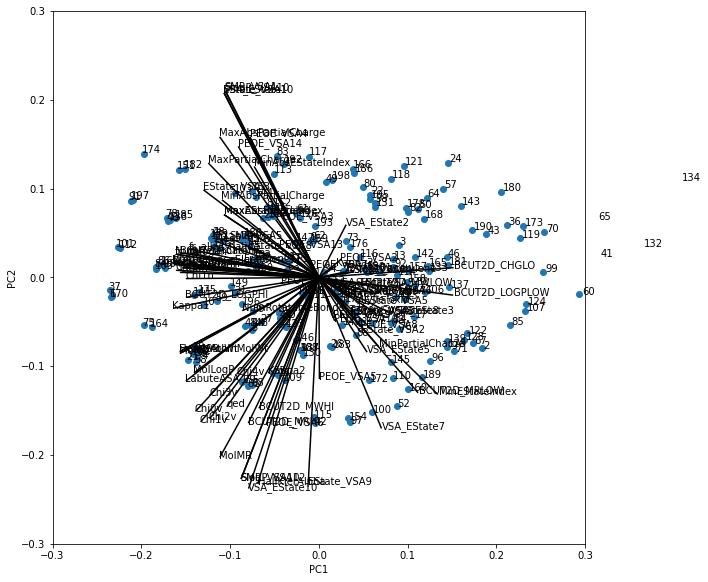

In [12]:
import matplotlib.pyplot as plt

# plot biplot with data
fig=plt.figure(figsize=(10,150))
ax=fig.add_subplot()
for i in range(len(desc_array.columns)):
    pc1_comp=pca.components_[0,i]
    pc2_comp=pca.components_[1,i]
    ax.plot([0,pc1_comp],[0,pc2_comp],color="k")
    ax.text(x=pc1_comp*1.01,y=pc2_comp*1.01,s=desc_array.columns[i])

biplot_scale=0.02
for i in range(200):
    pc1_comp=features[i,0]*biplot_scale
    pc2_comp=features[i,1]*biplot_scale
    ax.scatter(pc1_comp,pc2_comp,color="C0")
    ax.text(x=pc1_comp*1.01,y=pc2_comp*1.01,s=desc_array.index[i])
ax.set_aspect('equal', adjustable='box')
xylim=0.3
ax.set_xlim([-xylim,xylim])
ax.set_ylim([-xylim,xylim])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

plt.tight_layout()

In [13]:
PC_names=["PC{}".format(i+1) for i in range(6)]
ft_value_df=pd.DataFrame(features,columns=PC_names)
ft_df=pd.concat([smiles_df,mol_df,logp_df,ft_value_df],axis=1)
ft_df.head()

,SMILES,mol,LogP,PC1,PC2,PC3,PC4,PC5,PC6
0,[H]C(F)(F)C([H])([H])C(F)(F)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f5f60150080>,2.4732,-2.612576,3.464664,1.485989,0.635805,-0.959304,-0.039476
1,[H]C(F)(Cl)C([H])([H])C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f5f601e3670>,2.4732,-2.773286,3.797525,1.459615,0.370221,-0.931702,-0.060117
2,[H]C(Cl)=C=C([H])Cl,<rdkit.Chem.rdchem.Mol object at 0x7f5f6015d580>,2.0903,9.183354,-3.980349,-4.008474,1.818543,-0.253632,2.298699
3,[H]C([H])(F)C([H])(F)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f5f6015dad0>,1.4903,4.486766,1.840215,2.878089,-1.740045,1.326265,-1.712729
4,[H]C([H])(Cl)C(F)(F)C(F)(F)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f5f6015dda0>,2.6921,-5.928476,2.381269,0.427636,1.495675,-0.251883,2.434193


# HOMO-LUMO ギャップ計算

In [4]:
ft_df=pd.read_pickle("ProcessedData/MolLogPFeatures.pkl")
features=ft_df.iloc[:,3:].values

In [11]:
mol_df=ft_df[["mol"]]

In [12]:
# homo lumoギャップ計算
def func(mol_no):
    mol=mol_df.iloc[mol_no,0]
    mol=Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol,AllChem.ETKDGv3())
    xyz_text=Chem.MolToXYZBlock(mol)
    
    xyz_list=xyz_text.splitlines()
    psi4_input="\n".join(xyz_list[2:])

    # 計算手法（汎関数）、基底関数を設定
    level = "b3lyp/6-31G*"

    qua_geo = psi4.geometry(psi4_input)
    
    # quantum calc
    energy, wave_function=psi4.optimize(level,molecule=qua_geo,return_wfn=True)
    
    LUMO_idx=wave_function.nalpha()
    HOMO_idx=LUMO_idx-1

    lumo = wave_function.epsilon_a_subset("AO", "ALL").np[LUMO_idx]
    homo = wave_function.epsilon_a_subset("AO", "ALL").np[HOMO_idx]

    gap=lumo-homo
    
    return gap

In [13]:
bayes_opt_dis=bod.BayesianOptDiscrete(func,features)
bayes_opt_dis.initial_estimate()
bayes_opt_dis.minimumize_func(niter=1)

Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!


0.28778729820907223

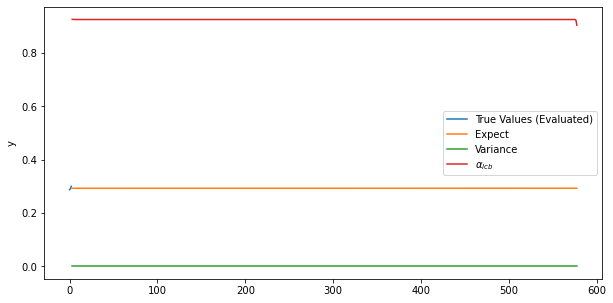

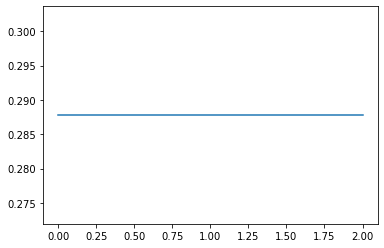

In [14]:
bayes_opt_dis.plot_result()
bayes_opt_dis.plot_trasition()

In [15]:
bayes_opt_dis2=bod.BayesianOptDiscrete(func,features)
bayes_opt_dis2.set_initial_estimate(
    bayes_opt_dis.train_target_no_list.copy(),
    bayes_opt_dis.train_y_list.copy()
)
bayes_opt_dis2.minimumize_func(niter=10)

Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization failed!


OptimizationConvergenceError: Could not converge geometry optimization in 4 iterations.

In [43]:
bayes_opt_dis2.train_target_no_list
bayes_opt_dis2.train_y

array([0.2877873 , 0.29138627, 0.30061918, 0.28847987, 0.30669687,
       0.26779038])

In [46]:
res_train_list=bayes_opt_dis2.train_target_no_list.copy()
res_train_y_list=bayes_opt_dis2.train_y_list.copy()

In [47]:
res_train_y_list.append(np.nan)

In [52]:
res_df=pd.DataFrame(columns=["no","gap"])
res_df["no"]=res_train_list
res_df["gap"]=res_train_y_list

In [54]:
res_df.to_pickle("ProcessedData/bayes_opt_res_df.pkl")

In [60]:
bayes_opt_dis3=bod.BayesianOptDiscrete(func,features)
bayes_opt_dis3.set_initial_estimate(
    bayes_opt_dis2.train_target_no_list[:-1].copy(),
    bayes_opt_dis2.train_y_list.copy()
)

In [61]:
bayes_opt_dis3.calculate_kernel()
bayes_opt_dis3.calculate_e_v()
bayes_opt_dis3.calculate_lcb()

In [ ]:
bayes_opt_dis3.plot_result()

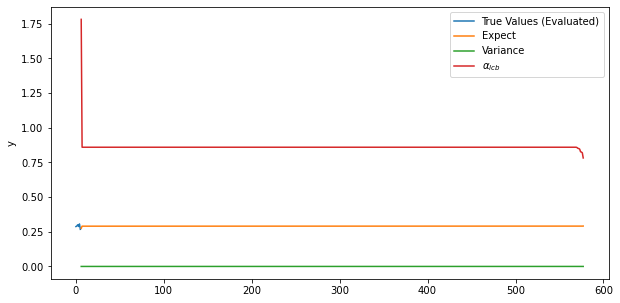

In [63]:
# 訓練データ数
train_num=len(bayes_opt_dis3.train_target_no_list)
train_no_arange=np.arange(train_num)

# 未評価データ数
remain_num=len(bayes_opt_dis3.remain_target_no_list)
remain_no_arange=np.arange(train_num,train_num+remain_num)

# 標準化された期待値に標準偏差を掛け、平均を足して訓練データと合わせる
scaled_expected_y=bayes_opt_dis3.expected_y*bayes_opt_dis3.std_train_y \
    +bayes_opt_dis3.mean_train_y
# 標準化されたvarianceに標準偏差の2乗を掛け、訓練データと合わせる
scaled_variance_y=bayes_opt_dis3.variance_y*bayes_opt_dis3.std_train_y**2
# 獲得関数
alpha=bayes_opt_dis3.alpha_lcb
# 獲得関数の大きい順(降順)に並び替える
descending=np.argsort(alpha)[::-1]

plt.figure(figsize=(10,5))
plt.plot(train_no_arange,bayes_opt_dis3.train_y,label="True Values (Evaluated)",color="C0")

plt.plot(remain_no_arange,scaled_expected_y[descending],label="Expect",color="C1")
plt.plot(remain_no_arange,scaled_variance_y[descending],label="Variance",color="C2")
plt.plot(remain_no_arange,alpha[descending],label="$\\alpha_{lcb}$",color="C3")
plt.ylabel("y")
plt.legend()
plt.show()

In [55]:
bayes_opt_dis2.train_target_no_list[:-1]

[502, 33, 236, 409, 253, 274]

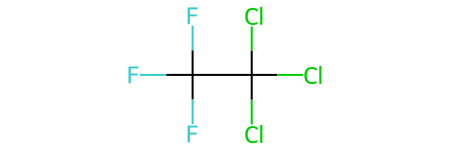

In [40]:
mol_df.iloc[bayes_opt_dis2.train_target_no_list[5],0]


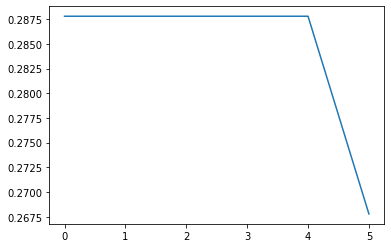

In [41]:
# bayes_opt_dis2.plot_result()
bayes_opt_dis2.plot_trasition()

In [16]:
mol=Chem.MolFromSmiles("C(C(F)(Cl)Cl)(F)(F)Cl")
mol=Chem.AddHs(mol)
Draw.MolToImage(mol,size=(100,100))

AllChem.EmbedMolecule(mol,AllChem.ETKDGv3())
xyz_text=Chem.MolToXYZBlock(mol)
print(xyz_text)

xyz_list=xyz_text.splitlines()
psi4_input="\n".join(xyz_list[2:])

#! Sample HF/cc-pVDZ H2O Computation
# psi4.set_memory('500 MB')

qua_geo = psi4.geometry(psi4_input)
# psi4.set_options({'reference': 'rhf'})
# 計算手法（汎関数）、基底関数を設定
level = "b3lyp/6-31G*"
energy, wave_function=psi4.optimize(level,molecule=qua_geo,return_wfn=True)

8

C      0.680239    0.330205    0.051521
C     -0.702443   -0.255342   -0.134271
F     -0.814050   -0.892391   -1.352229
Cl    -1.919796    1.009105    0.051191
Cl    -0.859396   -1.523979    1.107067
F      0.982567    1.263083   -0.934794
F      0.716579    1.005222    1.250793
Cl     1.916300   -0.935903   -0.039277



KeyboardInterrupt: 